In [58]:
#Data from the Amundson Sea

In [59]:
import glob, os
import pandas as pd
from pandas.compat import StringIO
import xarray as xr
import numpy as np

In [60]:
path='/home/wizard/Documents/observing_the_ocean/anna_wahlin/exercises/data/Exercise_2/'

In [119]:
import dask.dataframe as dd

df = pd.concat([(pd.read_csv(f,header=None,skiprows=1,nrows=4,sep='\s+=')).transpose().assign(ctd=os.path.basename(f).split('.')[0]) 
               for f in glob.glob(path+'OS*.dat')], ignore_index = True)

# df=df.set_index('ctd')
df.columns = df.iloc[0]
df=df.reindex(df.index.drop(0))
df=df[df.index % 2 != 0]  
df.rename(columns={'OSO0809_CTD_26058':'ctd'}, inplace=True)

dfHeader=df

df = pd.concat([pd.read_csv(f,sep='\s+',skiprows=7,names=['pres','Temp','S','rho']).assign(ctd=os.path.basename(f).split('.')[0]) 
                for f in glob.glob(path+'OS*.dat')], ignore_index = True)
# df_vars=df.set_index('ctd')
dfHeader

/home/wizard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,Date,Start_Time,Start_Lat,Start_Lon,ctd
1,2008/12/21,08:55:28,-72.4496,-116.1512,OSO0809_CTD_26058
3,2008/12/21,15:23:28,-72.4314,-115.9709,OSO0809_CTD_27060
5,2008/12/21,05:19:36,-72.5722,-116.541,OSO0809_CTD_25057
7,2008/12/21,18:47:32,-72.4401,-116.0072,OSO0809_CTD_27062
9,2008/12/21,17:13:53,-72.4358,-115.9854,OSO0809_CTD_27061
11,2008/12/21,21:29:25,-72.2672,-115.719,OSO0809_CTD_28063
13,2008/12/17,19:21:22,-71.8385,-114.1514,OSO0809_CTD_16033
15,2008/12/21,01:32:55,-72.7938,-117.1925,OSO0809_CTD_23055
17,2008/12/21,03:34:21,-72.6686,-116.829,OSO0809_CTD_24056
19,2008/12/21,12:20:48,-72.4224,-115.9552,OSO0809_CTD_27059


In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
grouped=df.groupby('ctd')


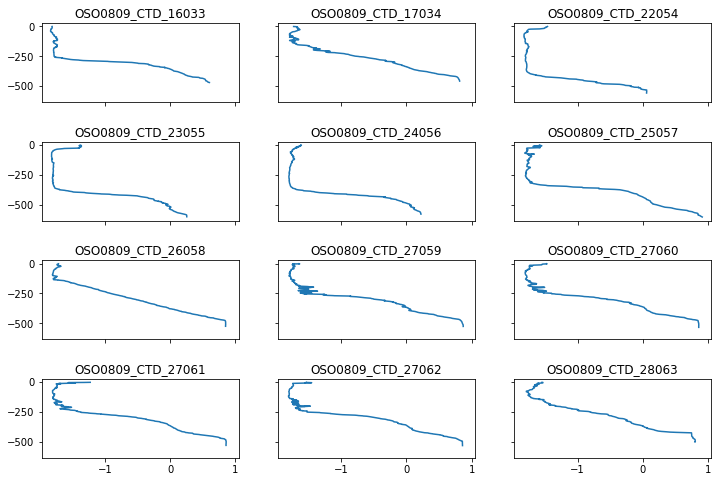

In [96]:
fig,ax=plt.subplots(4,3,figsize=[12,8],gridspec_kw=dict(hspace=0.5),sharex=True,sharey=True)

targets=zip(ax.flatten(),grouped.groups.keys())
for i, (axe, key) in enumerate(targets):
    axe.plot(grouped.get_group(key)['Temp'],grouped.get_group(key)['pres']*-1)
    axe.set_title('{0}'.format(key))
    axe.invert_yaxis()


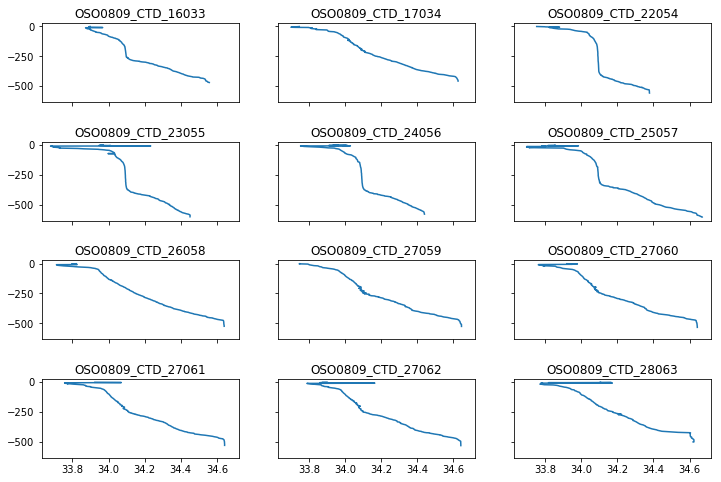

In [97]:
fig,ax=plt.subplots(4,3,figsize=[12,8],gridspec_kw=dict(hspace=0.5),sharey=True,sharex=True)

targets=zip(ax.flatten(),grouped.groups.keys())
for i, (axe, key) in enumerate(targets):
    axe.plot(grouped.get_group(key)['S'],grouped.get_group(key)['pres']*-1)
    axe.set_title('{0}'.format(key))
    axe.invert_yaxis()

Text(0,0.5,'Temperature')

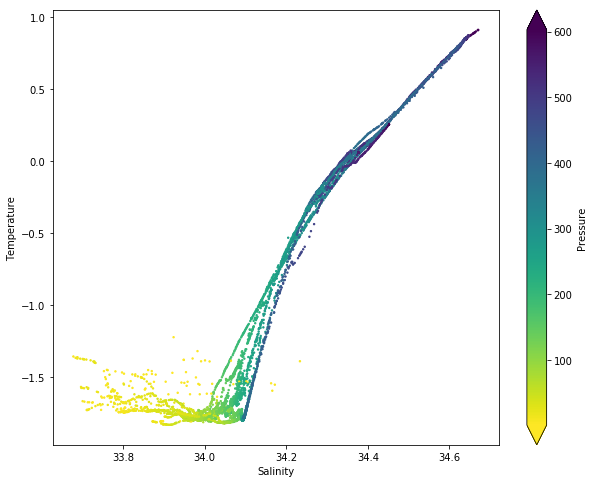

In [212]:
plt.figure(figsize=[10,8])
plt.scatter(df_vars.S,df_vars.Temp,s=2,c=df_vars.pres,cmap='viridis_r')
cbar=plt.colorbar(extend='both')
cbar.set_label('Pressure')
plt.xlabel('Salinity')
plt.ylabel('Temperature')


Water Masses: Winter water, Cicumpolar deep water

In [213]:
#Question 3
import gsw as gsw
df['pot_dens']=gsw.pot_rho_t_exact(df.S,df.Temp,df.pres,0)-1000

#neutral density
    
    

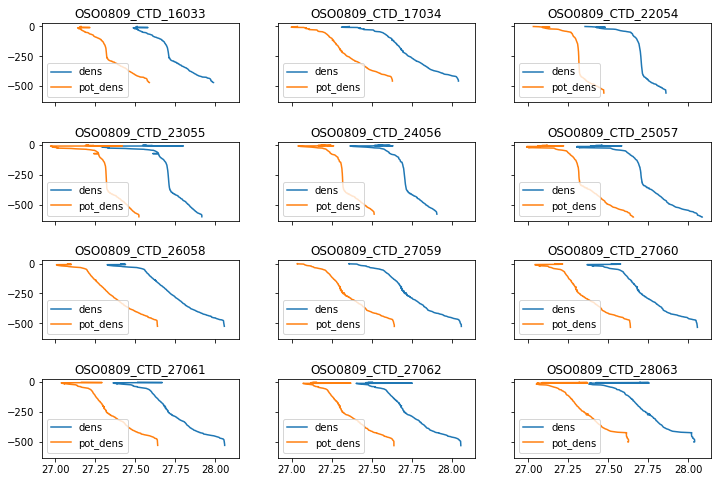

In [214]:
#plot
fig,ax=plt.subplots(4,3,figsize=[12,8],gridspec_kw=dict(hspace=0.5),sharey=True,sharex=True)

targets=zip(ax.flatten(),grouped.groups.keys())
for i, (axe, key) in enumerate(targets):
    axe.plot(grouped.get_group(key)['rho'],grouped.get_group(key)['pres']*-1,label='dens')
    axe.plot(grouped.get_group(key)['pot_dens'],grouped.get_group(key)['pres']*-1,label='pot_dens')
    axe.set_title('{0}'.format(key))
    axe.invert_yaxis()
    axe.legend()

In [369]:
#compute distance
def haversine(lat1, lon1, lat2, lon2):
    import numpy as np
    R=6378.137
    lat1, lon1, lat2, lon2 = map(np.deg2rad, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    total_m = (R * c)*1000
    return total_m

#convert lat lon objects to floats
dfHeader['lat']=dfHeader.Start_Lat.astype(float)
dfHeader['lon']=dfHeader.Start_Lon.astype(float)

dfHeader['dist']=np.cumsum(haversine(dfHeader.lat,dfHeader.lon,dfHeader.lat.shift(),dfHeader.lon.shift()))

In [216]:
#grid data

In [435]:
def griddata(var,depths,profiles,how='mean',interp_lim=4):
    from pandas import cut
    from numpy import arange, array, c_, nanmax

    y = array(var)
    depth = array(depths)
    dives = array(profiles)
    bins = arange(nanmax(depth) + 1)
    labels = c_[bins[:-1], bins[1:]].mean(axis=1)
    bins = cut(depth, bins, labels=labels)
    grp = pd.Series(y).groupby([dives, bins])
    grp_agg = getattr(grp, how)()
    gridded = grp_agg.unstack(level=0)
    gridded = gridded.reindex(labels.astype(float))
    gridded.index.name = 'depth'
    gridded.columns.name = 'ctd'
    gridded = gridded.reindex(index=labels)
    if interp_lim > 0:
        gridded = gridded.interpolate(limit=interp_lim).bfill(limit=interp_lim)
    return gridded

In [446]:
tg=griddata(df.Temp.T,df.pres,df.ctd).T
sg=griddata(df.S,df.pres,df.ctd).T
dg=griddata(df.pot_dens,df.pres,df.ctd).T
tg.index=(dfHeader.dist)
sg.index=(dfHeader.dist)
dg.index=(dfHeader.dist)

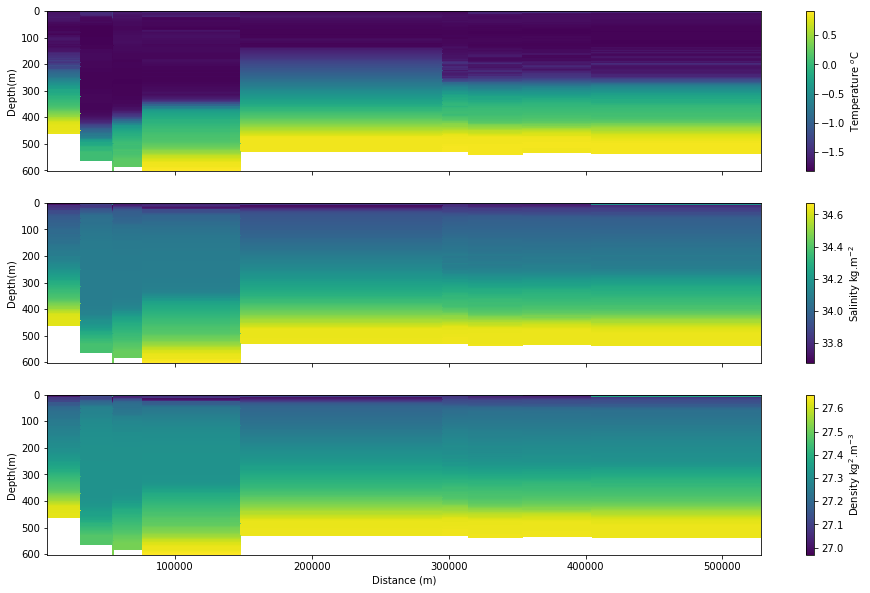

In [461]:
fig,ax=plt.subplots(3,1,figsize=[16,10],sharex=True)
xx,yy=np.meshgrid(tg.index[1:],tg.columns)
tp=ax[0].pcolormesh(xx,yy,tg.iloc[1:,:].T)
ax[0].invert_yaxis()
ax[0].set_ylabel('Depth(m)')
cbar=plt.colorbar(tp,ax=ax[0])
cbar.set_label('Temperature $^o$C')
sp=ax[1].pcolormesh(xx,yy,sg.iloc[1:,:].T)
ax[1].invert_yaxis()
ax[1].set_ylabel('Depth(m)')
cbar=plt.colorbar(sp,ax=ax[1])
cbar.set_label('Salinity kg.m$^{-2}$')
dp=ax[2].pcolormesh(xx,yy,dg.iloc[1:,:].T)
ax[2].invert_yaxis()
ax[2].set_ylabel('Depth(m)')
ax[2].set_xlabel('Distance (m)')
cbar=plt.colorbar(dp,ax=ax[2])
cbar.set_label('Density kg$^{2}$.m$^{-3}$')


In [514]:
#compute geostrophic shear

#create distance array
dist_array=dfHeader.dist.repeat(603).values.reshape(12,603)
dens_array=np.asarray(dg)
#compute horizontal density gradient
del_pot_dens0=(dens_array[1:,:]-dens_array[:-1,:])/(dist_array[1:,:]-dist_array[:-1,:])


array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-8.00471844e-08,  9.14170051e-07,  2.10636928e-06, ...,
                    nan,             nan,             nan],
       [ 7.46345851e-06,  5.72614382e-06,  5.16537564e-06, ...,
                    nan,             nan,             nan],
       ...,
       [-1.39964034e-07,  4.53282110e-07,  1.88512764e-06, ...,
                    nan,             nan,             nan],
       [-5.81766095e-07, -1.12944245e-06, -3.27062056e-06, ...,
                    nan,             nan,             nan],
       [ 1.86689619e-06,  1.28387728e-06,  1.56682430e-06, ...,
                    nan,             nan,             nan]])

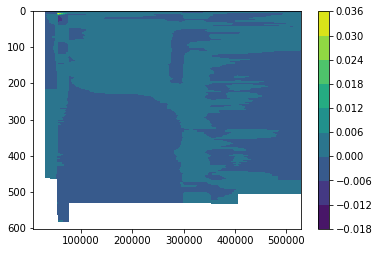

In [537]:
#compute coriolis acceleration
def coriolis_acc(lat,omega=0.729*10**-4):
    return 2*omega*np.sin(lat/360.*2*np.pi)

f=coriolis_acc(dfHeader.lat)
f_array=f.repeat(603).values.reshape(12,603)
g=9.8 # define gravitaional acceleration
ref_dens=1000.

#compute geostrophic vertical shear
geo_vert_shear=-((g/ref_dens)*(del_pot_dens0))/(-f_array[1:,:])
plt.contourf(xx,yy,geo_vert_shear.T)
plt.gca().invert_yaxis()
plt.colorbar(extend='both')